In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import os.path
import data
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
dvu.set_style()
import sys
sys.path.append('..')
import pandas as pd
import analyze_helper
from embgam import config
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# rs = data.load_fitted_results()
# rs.to_pickle(oj(config.results_dir, 'fitted_results_aggregated.pkl'))

rs = pd.read_pickle(oj(config.results_dir, 'fitted_results_aggregated.pkl'))
rr, r_sem = analyze_helper.average_seeds(rs)
rs.head()

,checkpoint,ngrams,subsample,all,norm,dataset,seed,layer,parsing,ignore_cache,padding,dataset_key_text,num_features,acc_train,acc_val
0,aatmasidha/distilbert-base-uncased-finetuned-e...,1,-1,all,,emotion,1,last_hidden_state_mean,,False,True,text,768,0.896938,0.8585
1,aatmasidha/distilbert-base-uncased-finetuned-e...,1,-1,all,,emotion,2,last_hidden_state_mean,,False,True,text,768,0.892938,0.8575
2,aatmasidha/distilbert-base-uncased-finetuned-e...,1,-1,all,,emotion,3,last_hidden_state_mean,,False,True,text,768,0.893938,0.8600
3,bert-base-uncased,1,-1,all,,emotion,1,pooler_output,,False,True,text,768,0.529438,0.5290
4,bert-base-uncased,1,-1,all,,emotion,2,pooler_output,,False,True,text,768,0.536312,0.5355


# calc accs for tables

In [10]:
def rename_checkpoint(checkpoint):
        cp = checkpoint.lower()
        if '/' in cp or 'finetune' in cp:
            if 'distilbert' in cp:
                return 'distilbert-finetuned'
            elif 'roberta' in cp:
                return 'roberta-finetuned'
            else:
                return 'bert-finetuned'
        else:
            return checkpoint

def get_acc_table(r):
    r = r[['dataset', 'checkpoint', 'layer', 'parsing'] + ['acc_val_print']]
    r.checkpoint = r.checkpoint.apply(rename_checkpoint)

    # group by (dataset, checkpoint, layer)
    rg = r.groupby(['dataset', 'checkpoint', 'layer', 'parsing'])

    # calc max acc
    rg = rg.max()

    # make acc table (dataset x [checkpoint, layer])
    rg = rg.reset_index().pivot(index='dataset',
                                 columns=['checkpoint', 'layer', 'parsing'],
                                 values='acc_val_print')
    rg.columns = ['___'.join(s) for s in rg.columns.to_flat_index()] # flatten index to tuples
    return rg

r = rr[rr.subsample == -1]
accs = get_acc_table(r)
r1 = r[r.ngrams == 1]
accs1 = get_acc_table(r1).add_suffix('___ngrams=1')
accs = accs.join(accs1)

/tmp/ipykernel_1948307/3946661003.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r.checkpoint = r.checkpoint.apply(rename_checkpoint)
/tmp/ipykernel_1948307/3946661003.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r.checkpoint = r.checkpoint.apply(rename_checkpoint)


In [11]:
accs.keys()

Index(['bert-base-uncased___last_hidden_state_mean___',
       'bert-base-uncased___pooler_output___',
       'bert-finetuned___last_hidden_state_mean___',
       'bert-finetuned___last_hidden_state_mean___noun_chunks',
       'bert-finetuned___pooler_output___',
       'countvectorizer___last_hidden_state_mean___',
       'distilbert-base-uncased___last_hidden_state_mean___',
       'distilbert-finetuned___last_hidden_state_mean___',
       'tfidfvectorizer___last_hidden_state_mean___',
       'bert-base-uncased___last_hidden_state_mean______ngrams=1',
       'bert-base-uncased___pooler_output______ngrams=1',
       'bert-finetuned___last_hidden_state_mean______ngrams=1',
       'bert-finetuned___last_hidden_state_mean___noun_chunks___ngrams=1',
       'bert-finetuned___pooler_output______ngrams=1',
       'countvectorizer___last_hidden_state_mean______ngrams=1',
       'distilbert-base-uncased___last_hidden_state_mean______ngrams=1',
       'distilbert-finetuned___last_hidden_state_m

In [12]:
accs.transpose()

dataset,emotion,financial_phrasebank,rotten_tomatoes,sst2,tweet_eval
bert-base-uncased___last_hidden_state_mean___,67.1\% $\pm$ 0.06\%,84.1\% $\pm$ 0.08\%,78.1\% $\pm$ 0.16\%,82.8\% $\pm$ 0.27\%,73.5\% $\pm$ 0.12\%
bert-base-uncased___pooler_output___,58.0\% $\pm$ 0.29\%,82.7\% $\pm$ 0.28\%,78.5\% $\pm$ 0.03\%,80.7\% $\pm$ 0.11\%,71.6\% $\pm$ 0.12\%
bert-finetuned___last_hidden_state_mean___,89.5\% $\pm$ 0.03\%,92.8\% $\pm$ 0.37\%,81.6\% $\pm$ 0.05\%,86.9\% $\pm$ 0.1\%,72.6\% $\pm$ 0.2\%
bert-finetuned___last_hidden_state_mean___noun_chunks,87.1\% $\pm$ 0.2\%,87.9\% $\pm$ 0.08\%,79.7\% $\pm$ 0.45\%,84.1\% $\pm$ 0.14\%,72.5\% $\pm$ 0.18\%
bert-finetuned___pooler_output___,89.8\% $\pm$ 0.07\%,93.5\% $\pm$ 0.05\%,81.3\% $\pm$ 0.13\%,87.8\% $\pm$ 0.21\%,71.7\% $\pm$ 0.06\%
countvectorizer___last_hidden_state_mean___,89.0\% $\pm$ 0.09\%,85.0\% $\pm$ 0.11\%,75.0\% $\pm$ 0.09\%,82.8\% $\pm$ 0.0\%,73.5\% $\pm$ 0.32\%
distilbert-base-uncased___last_hidden_state_mean___,68.8\% $\pm$ 0.11\%,85.8\% $\pm$ 0.34\%,78.5\% $\pm$ 0.34\%,81.7\% $\pm$ 0.07\%,72.7\% $\pm$ 0.2\%
distilbert-finetuned___last_hidden_state_mean___,87.5\% $\pm$ 0.11\%,81.7\% $\pm$ 0.34\%,79.8\% $\pm$ 0.08\%,86.8\% $\pm$ 0.1\%,73.5\% $\pm$ 0.19\%
tfidfvectorizer___last_hidden_state_mean___,89.2\% $\pm$ 0.04\%,84.9\% $\pm$ 0.16\%,75.9\% $\pm$ 0.06\%,83.4\% $\pm$ 0.11\%,73.1\% $\pm$ 0.19\%
bert-base-uncased___last_hidden_state_mean______ngrams=1,66.8\% $\pm$ 0.06\%,81.5\% $\pm$ 0.2\%,74.1\% $\pm$ 0.19\%,75.5\% $\pm$ 0.07\%,73.5\% $\pm$ 0.12\%


**best-model accs**

In [13]:
columns = {
    'bert-finetuned___last_hidden_state_mean___': '\\textbf{Emb-GAM}', #'\\textbf{Emb-grams (BERT finetuned)}',
    'countvectorizer___last_hidden_state_mean___': 'Bag of ngrams',
    'tfidfvectorizer___last_hidden_state_mean___': 'TF-IDF',
    'bert-finetuned___last_hidden_state_mean______ngrams=1': '\makecell[l]{Emb-GAM\\\\(unigrams only)}',    # 'Emb-GAM (Unigrams only)',# '\makecell{Emb-grams\\\\(BERT finetuned, Ngram size=1)}',    
}

tab = accs[list(columns.keys())].rename(columns=columns)
tab

# rename index
tab.index = map(analyze_helper.DSETS_RENAME_DICT.get, tab.index, tab.index)
# tab.index = tab.append(tab.pop())
# tab.round(2)

# tab2 = tab.apply(analyze_helper.bold_extreme_values, axis=1)
tab2 = tab
print(tab2.transpose().to_latex(escape=False))

\begin{tabular}{llllll}
\toprule
{} &              Emotion & Financial phrasebank &      Rotten tomatoes &                 SST2 &         Tweet (Hate) \\
\midrule
\textbf{Emb-GAM}                       &  89.5\% $\pm$ 0.03\% &  92.8\% $\pm$ 0.37\% &  81.6\% $\pm$ 0.05\% &   86.9\% $\pm$ 0.1\% &   72.6\% $\pm$ 0.2\% \\
Bag of ngrams                          &  89.0\% $\pm$ 0.09\% &  85.0\% $\pm$ 0.11\% &  75.0\% $\pm$ 0.09\% &   82.8\% $\pm$ 0.0\% &  73.5\% $\pm$ 0.32\% \\
TF-IDF                                 &  89.2\% $\pm$ 0.04\% &  84.9\% $\pm$ 0.16\% &  75.9\% $\pm$ 0.06\% &  83.4\% $\pm$ 0.11\% &  73.1\% $\pm$ 0.19\% \\
\makecell[l]{Emb-GAM\\(unigrams only)} &  87.2\% $\pm$ 0.06\% &  86.4\% $\pm$ 0.13\% &  76.8\% $\pm$ 0.19\% &  81.7\% $\pm$ 0.07\% &  72.2\% $\pm$ 0.07\% \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1948307/3804488000.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab2.transpose().to_latex(escape=False))


**model variations table**

In [17]:
columns = {
    'bert-finetuned___last_hidden_state_mean___': '\makecell{BERT finetuned}',
    'bert-finetuned___pooler_output___': '\makecell{BERT finetuned\\\\(pooler output)}',
    'bert-finetuned___last_hidden_state_mean___noun_chunks': '\makecell{BERT finetuned\\\\(noun chunks)}',    
    'bert-base-uncased___last_hidden_state_mean___': 'BERT',
    'bert-base-uncased___pooler_output___': '\makecell{BERT\\\\(pooler output)}',    
    'bert-base-uncased___last_hidden_state_mean___': 'BERT',
    'distilbert-base-uncased___last_hidden_state_mean___': 'DistilBERT finetuned',
    'distilbert-finetuned___last_hidden_state_mean___': 'DistilBERT',
}

tab = accs[list(columns.keys())].rename(columns=columns)
tab

# rename index
tab.index = map(analyze_helper.DSETS_RENAME_DICT.get, tab.index, tab.index)
tab = tab.round(3)

In [18]:
print(tab.transpose().to_latex(escape=False, column_format='c' + 'l' * (tab.shape[1] - 1)))

\begin{tabular}{cllllll}
\toprule
{} &              Emotion & Financial phrasebank &      Rotten tomatoes &                 SST2 &         Tweet (Hate) \\
\midrule
\makecell{BERT finetuned}                  &  89.5\% $\pm$ 0.03\% &  92.8\% $\pm$ 0.37\% &  81.6\% $\pm$ 0.05\% &   86.9\% $\pm$ 0.1\% &   72.6\% $\pm$ 0.2\% \\
\makecell{BERT finetuned\\(pooler output)} &  89.8\% $\pm$ 0.07\% &  93.5\% $\pm$ 0.05\% &  81.3\% $\pm$ 0.13\% &  87.8\% $\pm$ 0.21\% &  71.7\% $\pm$ 0.06\% \\
\makecell{BERT finetuned\\(noun chunks)}   &   87.1\% $\pm$ 0.2\% &  87.9\% $\pm$ 0.08\% &  79.7\% $\pm$ 0.45\% &  84.1\% $\pm$ 0.14\% &  72.5\% $\pm$ 0.18\% \\
BERT                                       &  67.1\% $\pm$ 0.06\% &  84.1\% $\pm$ 0.08\% &  78.1\% $\pm$ 0.16\% &  82.8\% $\pm$ 0.27\% &  73.5\% $\pm$ 0.12\% \\
\makecell{BERT\\(pooler output)}           &  58.0\% $\pm$ 0.29\% &  82.7\% $\pm$ 0.28\% &  78.5\% $\pm$ 0.03\% &  80.7\% $\pm$ 0.11\% &  71.6\% $\pm$ 0.12\% \\
DistilBERT finetuned           

/tmp/ipykernel_1948307/246522799.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab.transpose().to_latex(escape=False, column_format='c' + 'l' * (tab.shape[1] - 1)))


# all curves

/tmp/ipykernel_1948307/868802363.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r = r1.append(r3)
/tmp/ipykernel_1948307/868802363.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r = r1.append(r3)
/tmp/ipykernel_1948307/868802363.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r = r1.append(r3)
/tmp/ipykernel_1948307/868802363.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r = r1.append(r3)


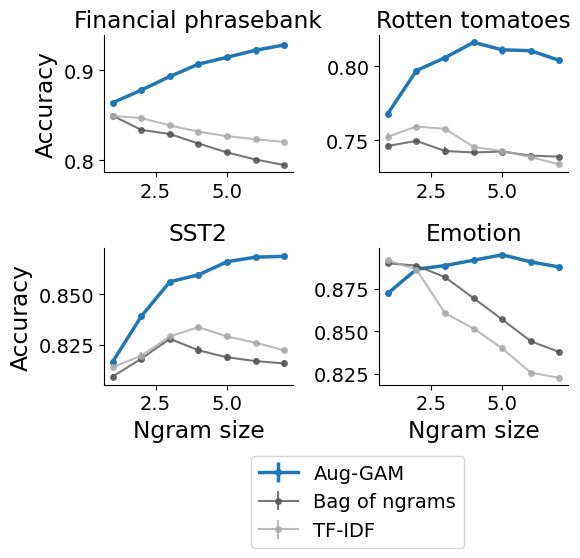

In [51]:
dvu.set_style()
plt.figure(figsize=(6, 4.75))
plt.rcParams['font.size'] = '14'

for i, dset in enumerate(['financial_phrasebank', 'rotten_tomatoes', 'sst2', 'emotion']):
    # r = rs[rs.dataset == dset]
    r = rr[rr.dataset == dset]    
    r = r[r.parsing == '']
    r1 = r[~r.checkpoint.str.lower().str.contains('bert')]
    # r2 = r[
    #     (r.checkpoint.apply(rename_checkpoint) == 'bert-base-uncased') & \
    #     (r.layer == 'last_hidden_state_mean')
    # ]
    r3 = r[
        (r.checkpoint.apply(rename_checkpoint) == 'bert-finetuned') & \
        (r.layer == 'last_hidden_state_mean')
    ]    
    # r = r1.append(r2).append(r3)
    r = r1.append(r3)

    plt.subplot(2, 2, i + 1)
    plt.title(f'{analyze_helper.DSETS_RENAME_DICT.get(dset)}', fontsize='large')
    d = r[(r.subsample == -1)]

    curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                   key=lambda x: analyze_helper.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
    # curve.append(curve.pop(0)) # move BERT to bottom
    for key, group in curve:
        g = group.sort_values('ngrams')
        if 'distilbert' in key[0].lower():
            label = analyze_helper.COLUMNS_RENAME_DICT.get(key[0], 'Emb-GAM (DistilBERT finetuned)')    
        else:
            label = analyze_helper.COLUMNS_RENAME_DICT.get(key[0], 'Aug-GAM')
        if 'Aug-GAM' in label:
            # plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2.5, color='black', ms=8)
            plt.errorbar(g.ngrams, g.acc_val, yerr=g.acc_val_sem, fmt='.-', label=label, lw=2.5, color='C0', ms=8)
        else:
            if label == 'Bag of ngrams':
                color = '#555'
            elif label == 'TF-IDF':
                color = '#AAA'
            # plt.plot(g.ngrams, g.acc_val, '.--', label=label, lw=1.5, alpha=0.8, ms=8)
            plt.errorbar(g.ngrams, g.acc_val, yerr=g.acc_val_sem, fmt='.-', label=label, lw=1.5, alpha=0.8, ms=8, color=color)
    if i % 2 == 0:
        plt.ylabel(f'Accuracy', fontsize='large')
    if i >= 2:
        plt.xlabel('Ngram size', fontsize='large')
    # plt.xlabel('Ngram size', fontsize='large')
    # plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#                 mode="expand", borderaxespad=0, ncol=3)
# plt.legend(bbox_to_anchor=(1.04, 1.0), loc="center left",
#            borderaxespad=0, labelcolor='linecolor')
# plt.legend(bbox_to_anchor=(1.04, 1.0), loc="center left",
        #    borderaxespad=0,)
plt.legend(fontsize='medium', bbox_to_anchor=(0.5, -0.45))
plt.savefig(f'acc_by_ngrams_full.pdf', bbox_inches='tight')
#     plt.show()    
    #     print(curve)

## older versions

In [ ]:
for dset in ['financial_phrasebank', 'rotten_tomatoes', 'sst2']: # rs.dataset.unique():
    r = rs[rs.dataset == dset]

    R = 1
    C = 3
    plt.figure(figsize=(12, 5))
    # plt.figure(figsize=(8, 12))
    for i, subsample in enumerate([100, 1000, -1]):
        plt.subplot(R, C, i + 1)
        plt.title('Num train=' + str(subsample))
        d = r[r.subsample == subsample]

        curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                       key=lambda x: data.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
        curve.append(curve.pop(0)) # move BERT to bottom
        for key, group in curve:
            g = group.sort_values('ngrams')
            label = data.COLUMNS_RENAME_DICT.get(key[0], 'BERT finetuned')
            if label == 'BERT finetuned':
                plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2, color='black')
            else:
                plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=1)
        plt.ylabel(f'Accuracy ({data.DSETS_RENAME_DICT.get(dset)})')
        plt.xlabel('N-gram size')
        plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(f'results/acc_by_ngrams_{dset}.pdf')
#     plt.show()    
    #     print(curve)

In [ ]:
plt.figure(figsize=(12, 4))
for i, dset in enumerate(['financial_phrasebank', 'rotten_tomatoes', 'sst2']):
    r = rs[rs.dataset == dset]
    plt.subplot(1, 3, i + 1)
    plt.title(f'{data.DSETS_RENAME_DICT.get(dset)}', fontsize='large')
    d = r[r.subsample == subsample]

    curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                   key=lambda x: data.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
    curve.append(curve.pop(0)) # move BERT to bottom
    for key, group in curve:
        g = group.sort_values('ngrams')
        label = data.COLUMNS_RENAME_DICT.get(key[0], 'BERT finetuned')
        if label == 'BERT finetuned':
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2.5, color='black')
        else:
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=1.5)
    plt.ylabel(f'Accuracy', fontsize='large')
    plt.xlabel('Ngram size', fontsize='large')
#     plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
plt.legend(labelcolor='linecolor', fontsize='large')
# plt.savefig(f'results/acc_by_ngrams_full.pdf')
#     plt.show()    
    #     print(curve)

## save best models

In [73]:
import embgam
df = deepcopy(rs)
df.checkpoint_clean = df.checkpoint.apply(rename_checkpoint)
df = df[(df.checkpoint_clean == 'bert-finetuned') * (df.subsample == -1) * (df['all'] == 'all') * (df['norm'] == '')]
idx = df.groupby('dataset')['acc_val'].transform(max) == df['acc_val']
df = df[idx]

/tmp/ipykernel_1630376/1702654884.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.checkpoint_clean = df.checkpoint.apply(rename_checkpoint)


In [76]:
def print_fname(row):
    out_dir_name = embgam.data.get_dir_name(
        row, seed=row.seed)
    save_dir = oj(config.results_dir, row.dataset, out_dir_name)
    save_dir += '-all'
    results_file = save_dir + '/results.pkl'
    out_name = 'results/best___' + os.path.basename(save_dir) + '.pkl'
    print('cp', results_file, out_name, '\n')
for i in range(df.shape[0]):
    print_fname(df.iloc[i])

cp /scratch/embgrams/embedded-ngrams/results/emotion/ngram=6_sub=-1_nateraw-bert-base-uncased-emotion__2-all/results.pkl results/best___ngram=6_sub=-1_nateraw-bert-base-uncased-emotion__2-all.pkl 

cp /scratch/embgrams/embedded-ngrams/results/financial_phrasebank/ngram=7_sub=-1_ahmedrachid-FinancialBERT-Sentiment-Analysis__3-all/results.pkl results/best___ngram=7_sub=-1_ahmedrachid-FinancialBERT-Sentiment-Analysis__3-all.pkl 

cp /scratch/embgrams/embedded-ngrams/results/rotten_tomatoes/ngram=5_sub=-1_textattack-bert-base-uncased-rotten_tomatoes__2-all/results.pkl results/best___ngram=5_sub=-1_textattack-bert-base-uncased-rotten_tomatoes__2-all.pkl 

cp /scratch/embgrams/embedded-ngrams/results/sst2/ngram=7_sub=-1_textattack-bert-base-uncased-SST-2__3-all/results.pkl results/best___ngram=7_sub=-1_textattack-bert-base-uncased-SST-2__3-all.pkl 

cp /scratch/embgrams/embedded-ngrams/results/tweet_eval/ngram=2_sub=-1_philschmid-BERT-tweet-eval-emotion__last_hidden_state_mean__1-all/results